In [1]:
import re
import nltk
import sqlite3
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



Нормализация

In [2]:
# Загружаем стоп-слова
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))
stop_symb = set(['.', ' '])

# Инициализация инструментов для нормализации текста
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_analyzer = MorphAnalyzer()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def normalize_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    normalized_tokens = []
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        if token.lemma not in stop_words and token.lemma not in stop_symb:
            normalized_tokens.append(token.lemma)
    return ' '.join(normalized_tokens)

conn = sqlite3.connect('articles.db')
cursor = conn.cursor()
cursor.execute("SELECT body FROM articles")
texts = cursor.fetchall()
conn.close()
texts = [text[0] for text in texts]

# Нормализация текстов
normalized_texts = [normalize_text(text) for text in texts]

# Печать нормализованных текстов
print(normalized_texts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['группировка войско « север » неделя освободить 12 населить пункт промежуточный итог наступление новый участок боевой действие подвести минобороны данные военный ведомство , указать период армия россия нанести поражение подразделение вооружить сила украина ( всу ) , число поразить позиция украинский войско район волчанск', 'фото : виталий тимкива / риа новость российский войско неделя нанести 28 групповой удар зона проведение специальный военный операция ( сво ) это журналист сообщить минобороны россия', 'фото : григорий сысоев / риа новость россия значительно увеличить жизненный цикл свой космический аппарат это рассказать президент рф владимир путин время общение студент харбинский политехнический университет , передавать риа новость', 'фото : police and border guard board / wikimedia власть эстония застроят земельный участок , который планироваться обменять россия это заявить министр внутренний дело лаури ляэнеметс , передавать err', 'фото : kremlin pool / globallookpress com вопро

Векторизация

In [3]:
# Векторизация текста
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(normalized_texts)
X.toarray()

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Сжатие векторов

In [4]:
# Сжатие векторов до 2 компонентов
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())


Кластеризация

In [5]:
# Кластеризация с помощью DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)
clusters = dbscan.fit_predict(X_pca)


Результаты

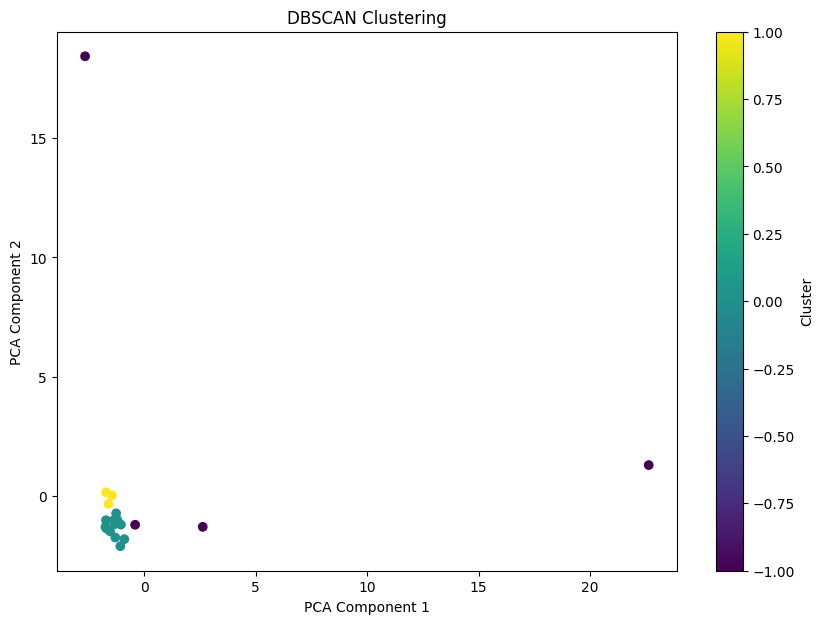

Cluster 0:
['Группировка войск «Север» за неделю освободила 12 населенных пунктов. Промежуточные итоги наступления на новом участке боевых действий подвело Минобороны.\nПо данным военного ведомства, за указанный период армия России нанесла поражения подразделениям Вооруженных сил Украины (ВСУ), в том числе поразила позиции украинских войск в районе Волчанска.', 'Фото: Виталий Тимкив / РИА Новости\nРоссийские войска за неделю нанесли 28 групповых ударов в зоне проведения специальной военной операции (СВО). Об этом журналистам сообщили в Минобороны России.', 'Фото: Police and Border Guard Board / Wikimedia\nВласти Эстонии застроят земельный участок, который планировалось обменять с Россией. Об этом заявил министр внутренних дел Лаури Ляэнеметс, передает ERR.', 'Фото: Valentyn Ogirenko / Reuters\nБлижайшие два месяца будут особенно сложными для Вооруженных сил Украины (ВСУ) в Харьковской области. Об этом заявил командир батальона ударных БПЛА 92-ой отдельной штурмовой бригады ВСУ Юрий Фед

In [6]:
# Визуализация результатов
df = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'cluster': clusters})

plt.figure(figsize=(10, 7))
plt.scatter(df['x'], df['y'], c=df['cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Выделение тем по кластерам
for cluster in set(clusters):
    print(f"Cluster {cluster}:")
    cluster_texts = [texts[i] for i in range(len(clusters)) if clusters[i] == cluster]
    print(cluster_texts)
